# Optic Flow
Inspired by: A Robust Road Vanishing Point Detection Adapted to the
Real-World Driving Scenes

Based on the:
1. analysis
2. stable motion detection
3. stationary point-based motion vector selection
4. angle-based RANSAC
(RANdom SAmple Consensus) voting

In [1]:
FLAG_OUTPUT_VIDEOS = True

In [2]:
import cv2
import numpy as np
import os
import copy
from matplotlib import pyplot as plt
import pickle
from multiprocessing import shared_memory, Pool

# create temp folder
if not os.path.exists('temp'):
    os.makedirs('temp')

In [3]:
file = "../../data/Dataset/unlabelled/241026_134333_062_FH.MP4"
# file = "test_15s_video.MP4"
# file = '2022_0813_191459_018.MP4'

cap = cv2.VideoCapture(file)
total_number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


file_name = os.path.splitext(os.path.basename(file))[0]

output_folder = "temp/" + file_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# reduce the number of frames
# total_number_of_frames = 150

print(f'Processing file: {file}')
print(f'Total number of frames: {total_number_of_frames}')
print(f'Output folder: {output_folder}')

Processing file: ../../data/Dataset/unlabelled/241026_134333_062_FH.MP4
Total number of frames: 1800
Output folder: temp/241026_134333_062_FH


### Frame handling

In [4]:
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # mask bottom
    # gray[-400:] = 0
    # # mask sides
    # gray[:, :100] = 0
    # gray[:, -100:] = 0
    # # blur
    # gray = cv2.GaussianBlur(gray, (3, 3 ), 0)
    return gray

def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print(f'Error reading frame {frame_number}')
        return None, None
    processed_frame = preprocess_frame(frame)
    return frame, processed_frame

# Video Builder

In [5]:
class VideoBuilder:
    def __init__(self, filename, fps):
        self.fps = fps
        self.output_file = filename
        self.recorder = None

    def add_frame(self, frame):
        if self.recorder is None:
            self.recorder = cv2.VideoWriter(self.output_file, cv2.VideoWriter_fourcc(*'XVID'), self.fps, (frame.shape[1], frame.shape[0]))

        self.recorder.write(frame)

    def stop_recording(self):
        if self.recorder is not None:
            self.recorder.release()
            self.recorder = None


# Motion Vector Detection

initialise motion detection parameters

In [6]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.3,
                       minDistance = 20,
                       blockSize = 7,)

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# TRACKING PARAMETERS
MINIMUM_TRACKED_POINTS = 400
MINIMUM_DISPLACEMENT = 1
MAXIMUM_TRAJECTORY_LENGTH = 30
THRESHOLD_REMOVE_POINTS_ON_SIDE = 200

# R-VP parameters
THRESHOLD_REMOVE_SHORT_TRAJECTORIES = 15

corner detection mask to select new points from a distance (Region of interest)

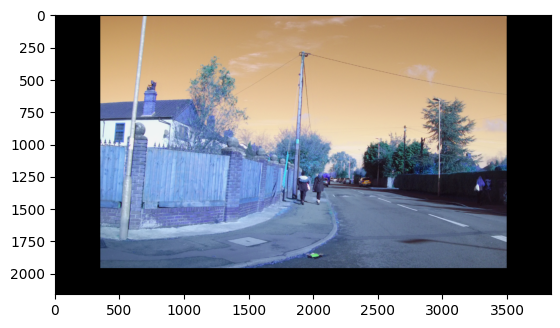

In [7]:
mask = np.ones((int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))), np.uint8)

# apply mask to select new points from a distance (Region of interest)
mask[-200:] = 0
mask[:, :350] = 0
mask[:, -350:] = 0

frame = get_frame(cap, 0)[0]
frame = cv2.bitwise_and(frame, frame, mask=mask)
plt.imshow(frame)

### Corner Feature Detection
Detect corners using Shi-Tomasi corner detection algorithm.

In [8]:
all_corners = []

corner_cache = {} # cache to optimise when tweaking parameters

def get_points_of_frame(frame_number):
    if frame_number in corner_cache:
        return corner_cache.get(frame_number)
    
    _, frame = get_frame(cap, frame_number) # using processed frame, not original

    # shi-tomasi corner detection
    corners = cv2.goodFeaturesToTrack(frame, mask = mask, **feature_params)

    corner_cache[frame_number] = corners
    return corners

In [9]:
frame = get_frame(cap, 0)[0]
corners = get_points_of_frame(0)

print(f'Initial number of corners: {len(corners)}')

Initial number of corners: 93


# Feature Tracking using Lucas-Kanade Optical Flow

#### Output video of the motion vectors

In [10]:
# random colours to label different lines
color = np.random.randint(0, 255, (400000, 3))

def get_frame_with_trajectories(frame_number, trajectories):
    original_frame, _ = get_frame(cap, frame_number)
    
    # Draw the full trajectories
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color) # Get a consistent color based on start position
        for j in range(1, len(points)): # Draw a line between all consecutive points
            a, b = points[j].ravel()
            c, d = points[j - 1].ravel()
            original_frame = cv2.line(original_frame, (int(a), int(b)), (int(c), int(d)), color[color_idx].tolist(), 2)

    # Draw current points as circles
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color) # Get a consistent color based on start position
        a, b = points[-1].ravel() # draw the last point
        original_frame = cv2.circle(original_frame, (int(a), int(b)), 5, color[color_idx].tolist(), -1)

    return original_frame


# create frames with trajectories and save them to a video
def output_video_of_trajectories(frame_trajectories, filename):
    video = VideoBuilder(filename, 30)
    for i in range(total_number_of_frames):
        frame_number = i
        trajectories = frame_trajectories[i]
        frame = get_frame_with_trajectories(frame_number, trajectories)
        video.add_frame(frame)
    video.stop_recording()

## Preprocessing Trajectory Helpers

#### Remove stationary points
Filter and remove points that are not moving more than Min_displacement

In [11]:
def filter_for_minimum_displacement(good_old, good_new):
    new_good_old = []
    new_good_new = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        new_x, new_y = new.ravel()
        old_x, old_y = old.ravel()
        if abs(new_x - old_x) > MINIMUM_DISPLACEMENT or abs(new_y - old_y) > MINIMUM_DISPLACEMENT:
            new_good_old.append(old)
            new_good_new.append(new)
    return np.array(new_good_old), np.array(new_good_new)

#### Clip max trajectory length
Hard limit length of a tracked point

In [12]:
def clip_max_trajectory(trajectory_list):
    return trajectory_list[-MAXIMUM_TRAJECTORY_LENGTH:]

#### Remove points that are too close to the left and right edge of the frame

In [13]:
def point_is_at_left_right_edge(point, image_shape):
    return point[0] < THRESHOLD_REMOVE_POINTS_ON_SIDE or point[0] > image_shape[1] - THRESHOLD_REMOVE_POINTS_ON_SIDE

## Perform tracking
- Points over many consecutive frames are considered stable motion vectors
- Can't be made concurrent since we need prior frame to calculate the optical flow

In [14]:
print("Processing frames for optical flow")
all_frame_trajectories = [] # store all trajectories for each frame

# initial frame and starting points
p0 = get_points_of_frame(0)
_, last_frame = get_frame(cap, 0)

# Init tracked points
trajectories = {tuple(p.ravel()): [p] for p in p0}
all_frame_trajectories.append(copy.deepcopy(trajectories))

for i in range(1, total_number_of_frames):
    _, frame_gray = get_frame(cap, i)

    if frame_gray is None:
        break
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(last_frame, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    # Filter out points that have not moved enough
    good_old, good_new = filter_for_minimum_displacement(good_old, good_new)

    new_trajectories = {}
    for new, old in zip(good_new, good_old):
        start_position = tuple(old.ravel())  # Use the original position as the key
        next_iterations_start_position = tuple(new.ravel())  # Use the new position as the key for the next iteration

        # Check if the point is at the edge of the image
        if point_is_at_left_right_edge(next_iterations_start_position, frame_gray.shape):
            continue

        if start_position in trajectories:
            # Update tracked points with new position
            trajectories[start_position].append(new)
            new_trajectories[next_iterations_start_position] = clip_max_trajectory(trajectories[start_position])

    # Replace old trajectories with updated ones that exclude lost points
    trajectories = new_trajectories
    
    all_frame_trajectories.append(copy.deepcopy(trajectories))

    # prepare for next iteration
    last_frame = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if len(p0) < MINIMUM_TRACKED_POINTS: # keep adding points once fall below 400
        new_points = get_points_of_frame(i)
        p0 = np.concatenate((p0, new_points), axis=0)
        for new_p in new_points:
            start_position = tuple(new_p.ravel())
            if start_position not in trajectories:
                trajectories[start_position] = [new_p]


Processing frames for optical flow
Error reading frame 1798


#### Output video of all unprocessed trajectories

In [15]:
if FLAG_OUTPUT_VIDEOS:
    print(f'Outputting video with trajectories to {output_folder}/all_trajectories.avi')
    # output_video_of_trajectories(all_frame_trajectories, f'{output_folder}/all_trajectories.avi')
else:
    print('Skipping video output')

Outputting video with trajectories to temp/241026_134333_062_FH/all_trajectories.avi


#### Display tracked points counts by frame

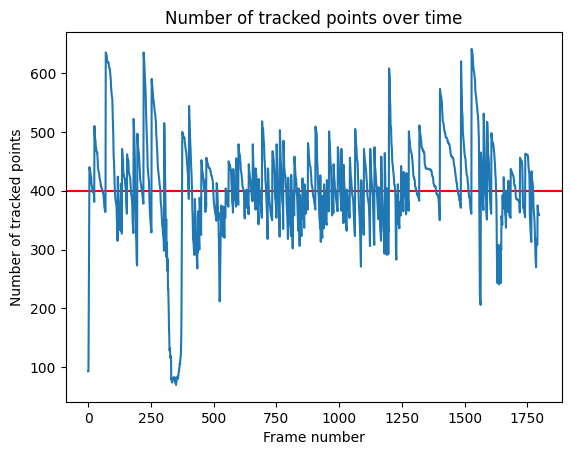

In [17]:
x = np.arange(0, len(all_frame_trajectories))
y = [len(frame_trajectories) for frame_trajectories in all_frame_trajectories]

plt.axhline(y=MINIMUM_TRACKED_POINTS, color='r', linestyle='-')
plt.title('Number of tracked points over time')
plt.xlabel('Frame number')
plt.ylabel('Number of tracked points')
plt.plot(x, y)

# Choosing stationary object motion vectors

remove trajectories with short history

In [18]:
temp = []
for frame in all_frame_trajectories:
    frame_vectors = {}
    for start_position, points in frame.items():
        if len(points) > THRESHOLD_REMOVE_SHORT_TRAJECTORIES:
            frame_vectors[start_position] = points
    temp.append(frame_vectors)

processed_frame_trajectories = temp

# R-VP Voting
Using RANSAC to find the best vanishing point

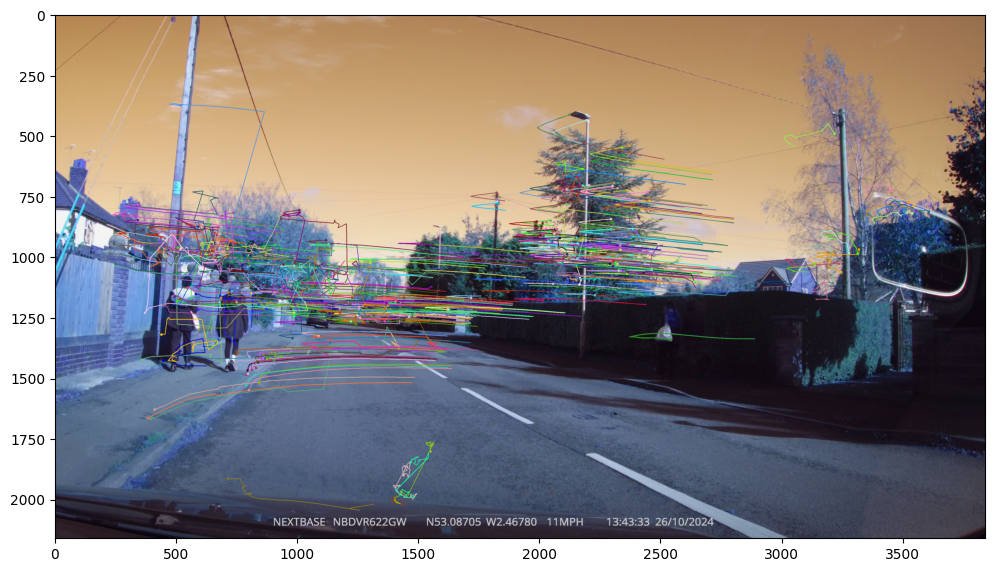

In [19]:
example_frame = 40

# filter related frame for short trajectories
example_frame_trajectories = processed_frame_trajectories[example_frame]

# display frame with trajectories
frame = get_frame_with_trajectories(example_frame, example_frame_trajectories)
plt.figure(figsize=(12, 12))
plt.imshow(frame)

#### RANSAC voting

In [20]:
def find_vanishing_point(line_segments, iterations=500, threshold=10,  inlier_ratio=0.6):
    best_vanishing_point = None
    max_inliers = 0
    total_segments = len(line_segments)
    
    # pre-solve slopes and intercepts
    slopes = []
    intercepts = []
    for (start, end) in line_segments:
        x1, y1 = start
        x2, y2 = end
        if x2 != x1:  # Non-vertical line
            m = (y2 - y1) / (x2 - x1)
            c = y1 - m * x1
        else:  # Vertical line case, set slope to None
            m, c = None, x1
        slopes.append(m)
        intercepts.append(c)
    
    slopes = np.array(slopes)
    intercepts = np.array(intercepts)
    
    for _ in range(iterations):
        # Randomly select two line segments
        idx1, idx2 = np.random.choice(total_segments, 2, replace=False)
        
        m1, c1 = slopes[idx1], intercepts[idx1]
        m2, c2 = slopes[idx2], intercepts[idx2]
        
        # Skip if parallel or identical (no unique intersection)
        if m1 == m2:
            continue
        
        # Calculate intersection point
        if m1 is not None and m2 is not None:
            # Both lines are non-vertical
            x_intersect = (c2 - c1) / (m1 - m2)
            y_intersect = m1 * x_intersect + c1
        elif m1 is None:  # Line 1 is vertical
            x_intersect = c1
            y_intersect = m2 * x_intersect + c2
        elif m2 is None:  # Line 2 is vertical
            x_intersect = c2
            y_intersect = m1 * x_intersect + c1
        
        intersection_point = np.array([x_intersect, y_intersect])
        
        # Calculate distances for all line segments to this intersection point
        distances = []
        for i, (m, c) in enumerate(zip(slopes, intercepts)):
            if m is not None:
                # Non-vertical line: calculate perpendicular distance
                y_hat = m * x_intersect + c
                distance = abs(y_hat - y_intersect)
            else:
                # Vertical line: distance is horizontal distance
                distance = abs(x_intersect - c)
            distances.append(distance)
        
        distances = np.array(distances)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)
        
        # Update best vanishing point if this one has more inliers
        if num_inliers > max_inliers:
            best_vanishing_point = intersection_point
            max_inliers = num_inliers
            
            # Early stopping if enough inliers found
            if max_inliers / total_segments >= inlier_ratio:
                break
    
    return best_vanishing_point, max_inliers

In [21]:
ransac_vectors = []

for start_position, points in example_frame_trajectories.items():
    for i in range(1, len(points)):
        # Store both start and end points of each vector
        start_point = points[i - 1].ravel()
        end_point = points[i].ravel()
        ransac_vectors.append([start_point, end_point])

ransac_vectors = np.array(ransac_vectors)

vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)

print("Vanishing Point:", vanishing_point)
print("Number of Inliers:", inliers_count)

Vanishing Point: [2294.0403 1031.3281]
Number of Inliers: 707


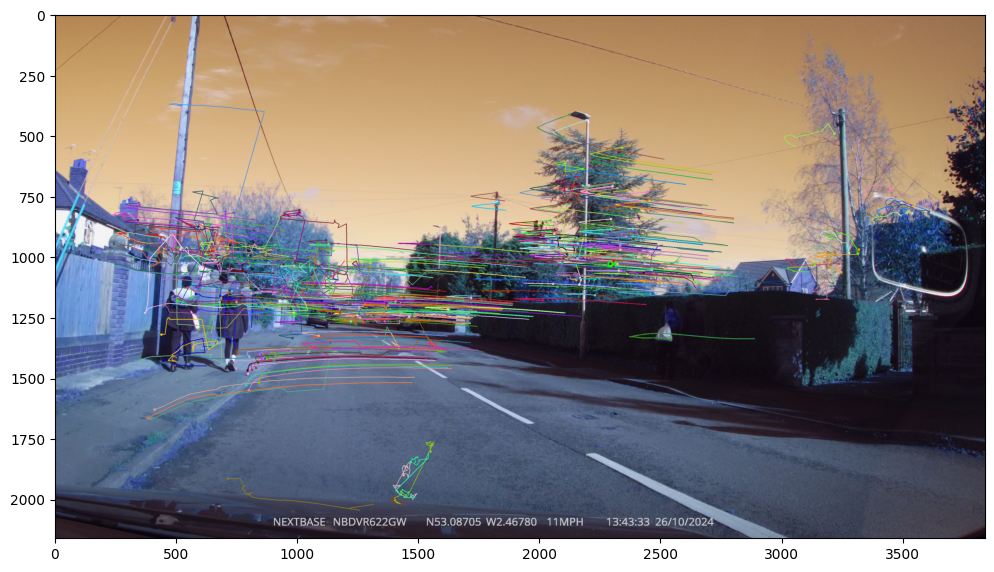

In [22]:
frame = get_frame_with_trajectories(example_frame, example_frame_trajectories)

# Draw vp
if vanishing_point is not None:
    frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 6)

plt.figure(figsize=(12, 12))
plt.imshow(frame)

#### Find R-VP using RANSAC on all frames
Run R-VP voting on all frames and add the best vanishing point to all_vp

In [ ]:
# Step 1: Serialize each frame separately and store it in shared memory
shared_memory_blocks = []
for frame_data in processed_frame_trajectories:
    serialized_frame = pickle.dumps(frame_data)
    shm = shared_memory.SharedMemory(create=True, size=len(serialized_frame))
    shm.buf[:len(serialized_frame)] = serialized_frame  # Copy serialized data to shared memory
    shared_memory_blocks.append(shm)  # Store each shared memory block

In [24]:
def process_single_frame_r_vp(shm_name):
    # Access shared memory for the specified frame
    existing_shm = shared_memory.SharedMemory(name=shm_name)
    serialized_frame = bytes(existing_shm.buf[:])
    shared_processed_frame_trajectories = pickle.loads(serialized_frame)
    existing_shm.close()
    existing_shm.unlink()
    
    ransac_vectors = []

    for start_position, points in shared_processed_frame_trajectories.items():
        for i in range(1, len(points)):
            start_point = points[i - 1].ravel()
            end_point = points[i].ravel()
            ransac_vectors.append([start_point, end_point])
    
    ransac_vectors = np.array(ransac_vectors)

    if len(ransac_vectors) < 2:
        return np.array([0, 0])
    
    vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)


    return vanishing_point

Run for all concurrently 

In [25]:
print ("Processing all frames for vanishing points")

with Pool() as pool:
    # Use pool.map to process each frame in parallel
    all_vp = pool.map(process_single_frame_r_vp, [shm.name for shm in shared_memory_blocks])

all_vp = np.array(all_vp)

Processing all frames for vanishing points


In [26]:
def output_video_of_R_VP(VP, filename):
    video = VideoBuilder(filename, 30)
    for i in range(0, len(VP)):
        frame_number = i
        vanishing_point = VP[i]
        frame = get_frame_with_trajectories(frame_number, processed_frame_trajectories[frame_number])
        if vanishing_point is not None:
            frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 5)
        video.add_frame(frame)
    video.stop_recording()


if FLAG_OUTPUT_VIDEOS:
    print(f'Outputting video with vanishing points to {output_folder}/all_vp.avi')
    output_video_of_R_VP(all_vp, f'{output_folder}/all_vp.avi')
else:
    print('Skipping video output')

Outputting video with vanishing points to temp/241026_134333_062_FH/all_vp.avi


# Save results

In [27]:
# output all trajectories and vanishing points
# np.save('temp/all_trajectories.npy', all_frame_trajectories) # too large to save
np.save(f'{output_folder}/all_vp.npy', all_vp)